# Eyes on the Road: Factors that Lead to Vehicular Accidents in New York City

---

## Import Libraries, Access API,  Create DataFrame, and Sample Data

In [14]:
# Ignore non-fatal warnings
import warnings
warnings.filterwarnings("ignore")

# Import other dependencies, including sodapy, which is identified in the API docs as crucial
import pandas as pd
from sodapy import Socrata # as directed by API admin
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress
import json
import os
import calendar

# Import API keys & app tokens
from api_keys import api_key_regular
from api_keys import api_key_secret
from api_keys import app_token_regular
from api_keys import app_token_secret

# Create full url for API that includes app token
client = Socrata("data.cityofnewyork.us", app_token_regular)

# Return results as a JSON
results = client.get("h9gi-nx95")

# Convert to pandas DataFrame
results_values_df = pd.DataFrame.from_records(results)

# Print all column names
column_names = results_values_df.columns
for name in column_names:
    print(name)

# Sample values for initial exploration
results_values_df.head(5)

crash_date
crash_time
on_street_name
off_street_name
number_of_persons_injured
number_of_persons_killed
number_of_pedestrians_injured
number_of_pedestrians_killed
number_of_cyclist_injured
number_of_cyclist_killed
number_of_motorist_injured
number_of_motorist_killed
contributing_factor_vehicle_1
contributing_factor_vehicle_2
collision_id
vehicle_type_code1
vehicle_type_code2
borough
zip_code
latitude
longitude
location
cross_street_name
contributing_factor_vehicle_3
vehicle_type_code_3
contributing_factor_vehicle_4
vehicle_type_code_4
contributing_factor_vehicle_5
vehicle_type_code_5


,crash_date,crash_time,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,latitude,longitude,location,cross_street_name,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5
0,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-03-26T00:00:00.000,11:45,QUEENSBORO BRIDGE UPPER,NaN,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-06-29T00:00:00.000,6:55,THROGS NECK BRIDGE,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-11T00:00:00.000,9:35,NaN,NaN,0,0,0,0,0,0,...,40.667202,-73.8665,"{'latitude': '40.667202', 'longitude': '-73.86...",1211 LORING AVENUE,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-12-14T00:00:00.000,8:13,SARATOGA AVENUE,DECATUR STREET,0,0,0,0,0,0,...,40.683304,-73.917274,"{'latitude': '40.683304', 'longitude': '-73.91...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


## DataFrame Clean-up and Hygiene

In [15]:
# Exclude columns that are unnecessary for the analysis
excluded_columns = ["on_street_name", "off_street_name", "contributing_factor_vehicle_2", "vehicle_type_code2", "zip_code", "latitude", "longitude",
"location", "cross_street_name", "cross_street_name", "contributing_factor_vehicle_3", "vehicle_type_code_3", "contributing_factor_vehicle_4", "vehicle_type_code_4", "contributing_factor_vehicle_5", "vehicle_type_code_5"]
filtered_df = results_values_df.loc[:, ~results_values_df.columns.isin(excluded_columns)]

# Drop rows with missing values
filtered_df = filtered_df.dropna()

# Drop rows where "contributing_factor_vehicle_1" is "Unspecified"
filtered_df = filtered_df[filtered_df["contributing_factor_vehicle_1"] != "Unspecified"]

# Reorder columns with "collision_id" as the first column so that each crash can be easily identified if needed
column_order = ["collision_id"] + [col for col in filtered_df.columns if col != "collision_id"]
filtered_df = filtered_df[column_order]

# Counts by column, to make sure analysis still has a sufficient number of records after previous drops
column_counts = filtered_df.count()
print(column_counts)

# Sample values to verify modifications to the data
filtered_df.head(5)

collision_id                     456
crash_date                       456
crash_time                       456
number_of_persons_injured        456
number_of_persons_killed         456
number_of_pedestrians_injured    456
number_of_pedestrians_killed     456
number_of_cyclist_injured        456
number_of_cyclist_killed         456
number_of_motorist_injured       456
number_of_motorist_killed        456
contributing_factor_vehicle_1    456
vehicle_type_code1               456
borough                          456
dtype: int64


,collision_id,crash_date,crash_time,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,vehicle_type_code1,borough
8,4487074,2021-12-14T00:00:00.000,21:10,0,0,0,0,0,0,0,0,Driver Inexperience,Sedan,BROOKLYN
9,4486519,2021-12-14T00:00:00.000,14:58,0,0,0,0,0,0,0,0,Passing Too Closely,Sedan,MANHATTAN
11,4487127,2021-12-14T00:00:00.000,16:50,0,0,0,0,0,0,0,0,Turning Improperly,Sedan,QUEENS
14,4486635,2021-12-14T00:00:00.000,23:10,2,0,0,0,0,0,2,0,Reaction to Uninvolved Vehicle,Sedan,QUEENS
15,4486604,2021-12-14T00:00:00.000,17:58,0,0,0,0,0,0,0,0,Passing Too Closely,Tanker,BROOKLYN


## Map to Establish the Scope of the Problem of Vehicular Accidents

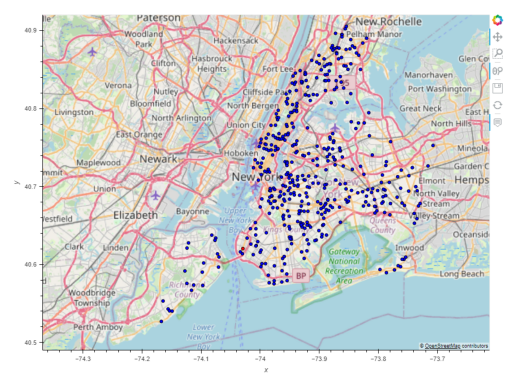

In [16]:
# NOTE: This map was created using Python, but requires numerous pip installs for the libraries necessary to generate it
# We felt it better to provide a post-execution scan than require the reviewer to do extra prep work to view the map

# Read the image file of the map with datapoints for all accidents in the period of study
image = plt.imread("plots/map_crashes.png")

# Display the map image
plt.imshow(image)
plt.axis('off')  # Remove axis ticks and labels
plt.show()

## Initial Plots for Exploration

## Bar Plot (absolute & percentage values) - Overall

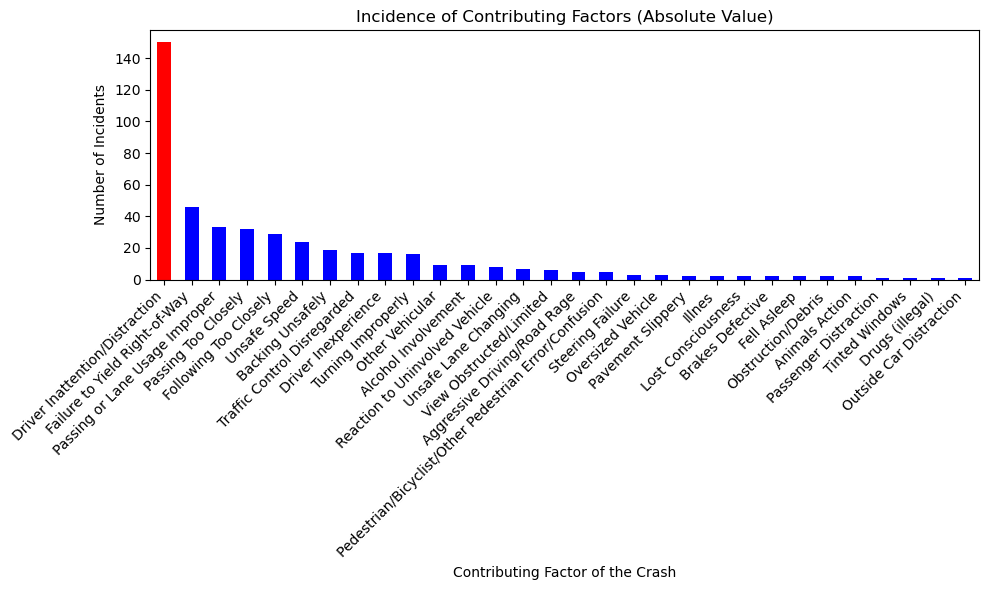

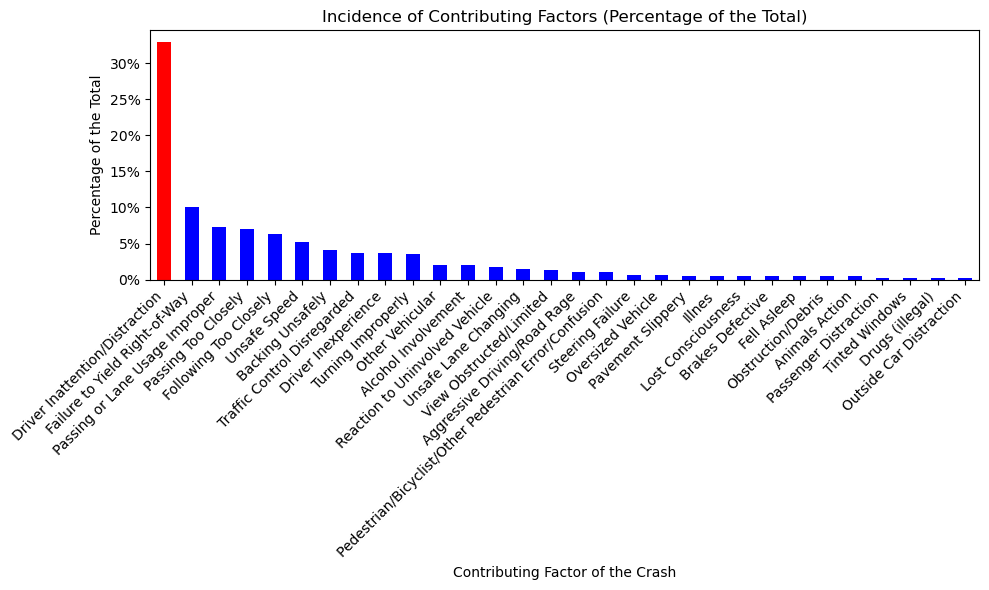

In [28]:
# Calculate factor counts and percentages
factor_counts = filtered_df["contributing_factor_vehicle_1"].value_counts()
factor_percentages = filtered_df["contributing_factor_vehicle_1"].value_counts(normalize=True) * 100

# Create a bar plot for absolute numbers of contributing factors of vehicular crashes
fig, ax = plt.subplots(figsize=(10, 6))
factor_counts.plot(kind="bar", ax=ax, color=["red"] + ["blue"] * (len(factor_counts) - 1))
ax.set_xlabel("Contributing Factor of the Crash")
ax.set_ylabel("Number of Incidents")
ax.set_title("Incidence of Contributing Factors (Absolute Value)")

# Rotate x-axis labels diagonally, to be more easily read
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout and spacing
plt.tight_layout()

# Save the bar plot as png to a subdirectory for the presentation
plt.savefig("plots/absolute_number_of_crashes_barplot.png")

# Display the bar plot
plt.show()

# Create a bar plot, this time for percentages with percent signs
fig, ax = plt.subplots(figsize=(10, 6))
factor_percentages.plot(kind="bar", ax=ax, color=["red"] + ["blue"] * (len(factor_counts) - 1))
ax.set_xlabel("Contributing Factor of the Crash")
ax.set_ylabel("Percentage of the Total")
ax.set_title("Incidence of Contributing Factors (Percentage of the Total)")
ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))

# Rotate x-axis labels diagonally
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust layout and spacing
plt.tight_layout()

# Save the bar plot for percentages as png for the presentation
plt.savefig("plots/percentage_of_crashes_barplot.png")

# Display the bar plot for percentages
plt.show()

## Initial Plots for Exploration

## Pie Plot (percentage values) - Overall

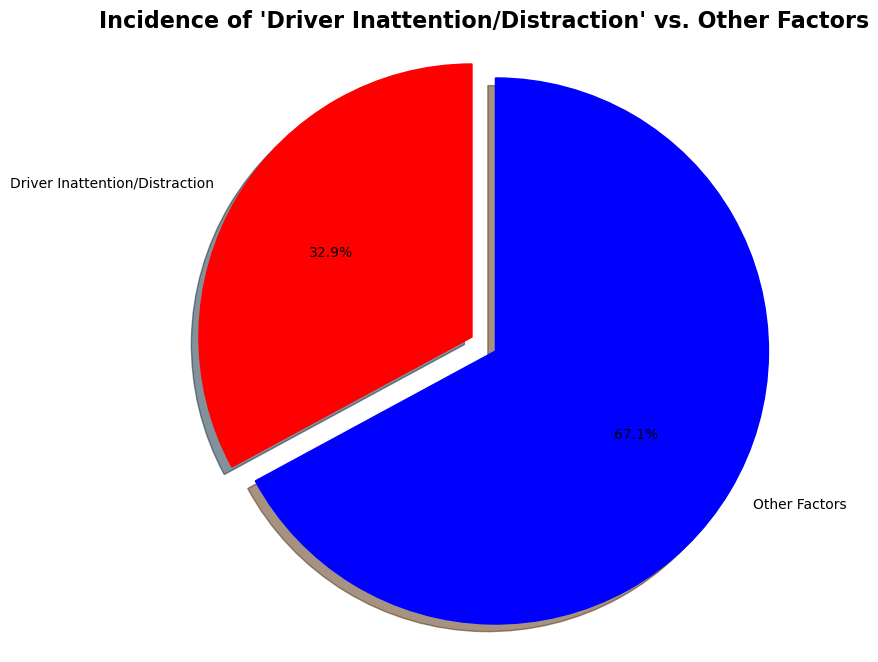

In [18]:
# Calculate sizes and labels for the pie plot
sizes = [
    filtered_df["contributing_factor_vehicle_1"].value_counts()["Driver Inattention/Distraction"],
    filtered_df["contributing_factor_vehicle_1"].value_counts().sum() - filtered_df["contributing_factor_vehicle_1"].value_counts()["Driver Inattention/Distraction"]
]
labels = ["Driver Inattention/Distraction", "Other Factors"]

# Define explode values to highlight "Driver Inattention/Distraction"
explode = (0.1, 0)

# Create a pie plot for "Driver Inattention/Distraction" vs. other factors
fig, ax = plt.subplots(figsize=(8, 8))
wedges, _, _ = ax.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', startangle=90, shadow=True)
ax.axis('equal')

# Set colors for the wedges
wedges[0].set_color('red')
wedges[1].set_color('blue')

# Set title properties
ax.set_title("Incidence of 'Driver Inattention/Distraction' vs. Other Factors", fontsize=16, fontweight='bold')

# Save the pie plot as a png file for the presentation
plt.savefig("plots/percentage_of_crashes_pieplot.png", bbox_inches='tight')

# Display the pie plot
plt.show()

## Plots to Investigate How Vehicular Collisions Interact with Other Factors

## Type of Persons Involved (three plots)

Driver Inattention/Distraction - 28
Following Too Closely - 15
Failure to Yield Right-of-Way - 15
Traffic Control Disregarded - 10
Unsafe Speed - 4
Passing or Lane Usage Improper - 4
Driver Inexperience - 4
Reaction to Uninvolved Vehicle - 3
Passing Too Closely - 3
Other Vehicular - 3


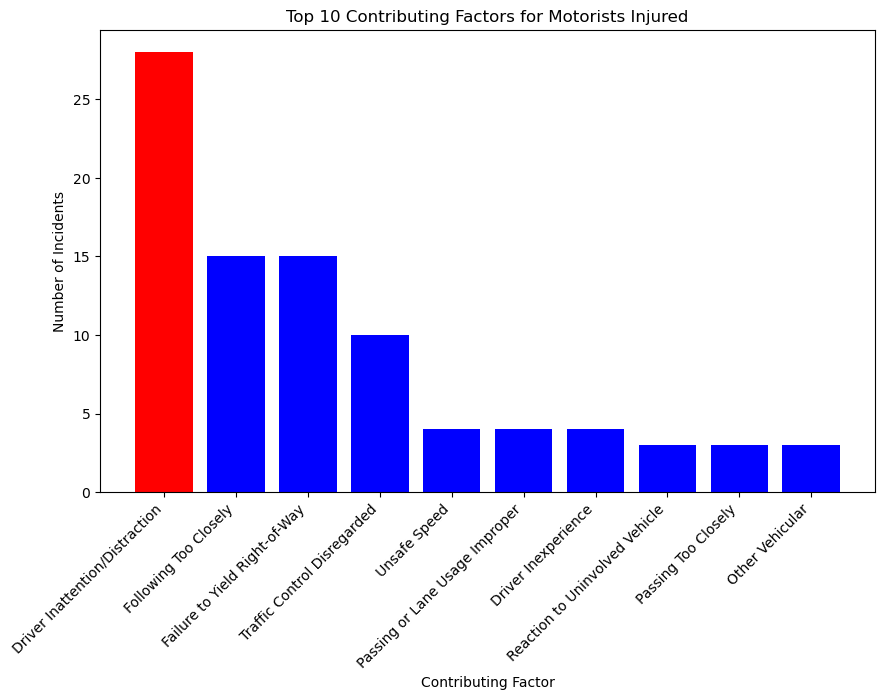

In [19]:
# Convert the column "number_of_motorist_injured" to numeric
filtered_df["number_of_motorist_injured"] = pd.to_numeric(filtered_df["number_of_motorist_injured"], errors="coerce")

# Filter the dataframe for motorists
motorist_df = filtered_df[filtered_df["number_of_motorist_injured"] > 0].copy()

# Get the top 10 contributing factors for motorists
top_factors_motorist = motorist_df["contributing_factor_vehicle_1"].value_counts().nlargest(10)

# Create the plot for motorists
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart for motorists
colors = ['r'] + ['b'] * (len(top_factors_motorist) - 1)  # Set first bar color as red
ax.bar(top_factors_motorist.index, top_factors_motorist.values, color=colors)

# Set axis labels and title for motorists
ax.set_xlabel("Contributing Factor")
ax.set_ylabel("Number of Incidents")
ax.set_title("Top 10 Contributing Factors for Motorists Injured")

# Rotate x-axis labels diagonally
ax.tick_params(axis='x', rotation=45)

# Adjust the position of x-axis labels
ax.set_xticklabels(top_factors_motorist.index, rotation=45, ha='right')

# Adjust layout and spacing
plt.tight_layout()

# Save the bar plot for motorists as a png file
plt.savefig("plots/motorists_injured_barplot.png")

# Get the top ten contributing factors by volume
top_factors_list = top_factors_motorist.reset_index().values.tolist()
# Print the list of top contributing factors by volume
for factor in top_factors_list:
    print(factor[0], "-", factor[1])

# Display the bar plot for motorists
plt.show()

Driver Inattention/Distraction - 12
Failure to Yield Right-of-Way - 10
Backing Unsafely - 2
Unsafe Speed - 2
Aggressive Driving/Road Rage - 1
View Obstructed/Limited - 1
Tinted Windows - 1
Turning Improperly - 1
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion - 1
Reaction to Uninvolved Vehicle - 1


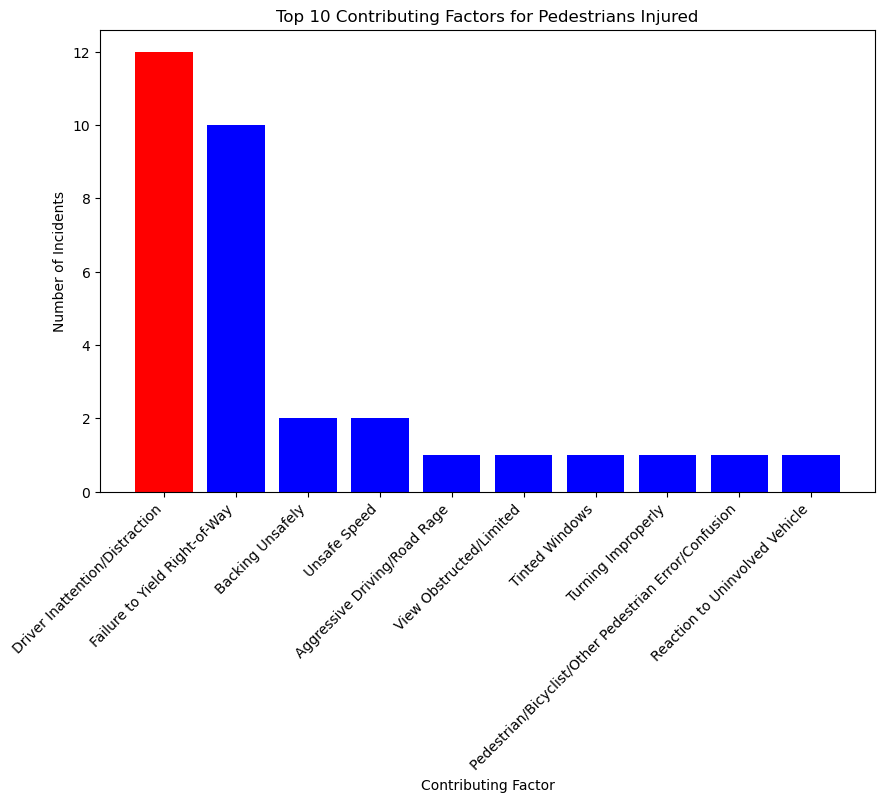

In [20]:
# Convert the column "number_of_pedestrians_injured" to numeric
filtered_df["number_of_pedestrians_injured"] = pd.to_numeric(filtered_df["number_of_pedestrians_injured"], errors="coerce")

# Filter the dataframe for pedestrians
pedestrians_df = filtered_df[filtered_df["number_of_pedestrians_injured"] > 0].copy()

# Get the top 10 contributing factors for pedestrians
top_factors_pedestrians = pedestrians_df["contributing_factor_vehicle_1"].value_counts().nlargest(10)

# Create the plot for pedestrians
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart for pedestrians
colors = ['r'] + ['b'] * (len(top_factors_pedestrians) - 1)  # Set first bar color as red
ax.bar(top_factors_pedestrians.index, top_factors_pedestrians.values, color=colors)

# Set axis labels and title for pedestrians
ax.set_xlabel("Contributing Factor")
ax.set_ylabel("Number of Incidents")
ax.set_title("Top 10 Contributing Factors for Pedestrians Injured")

# Rotate x-axis labels diagonally
ax.tick_params(axis='x', rotation=45)

# Adjust the position of x-axis labels
ax.set_xticklabels(top_factors_pedestrians.index, rotation=45, ha='right')

# Adjust layout and spacing
plt.tight_layout()

# Save the bar plot for pedestrians as a png file
plt.savefig("plots/pedestrians_injured_barplot.png")

# Get the top ten contributing factors by volume
top_factors_list2 = top_factors_pedestrians.reset_index().values.tolist()
# Print the list of top contributing factors by volume
for factor2 in top_factors_list2:
    print(factor2[0], "-", factor2[1])

# Display the bar plot for pedestrians
plt.show()

Driver Inattention/Distraction - 6
Following Too Closely - 3
Passing or Lane Usage Improper - 3
Failure to Yield Right-of-Way - 3
View Obstructed/Limited - 2
Turning Improperly - 2
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion - 2
Passenger Distraction - 1
Alcohol Involvement - 1
Unsafe Speed - 1


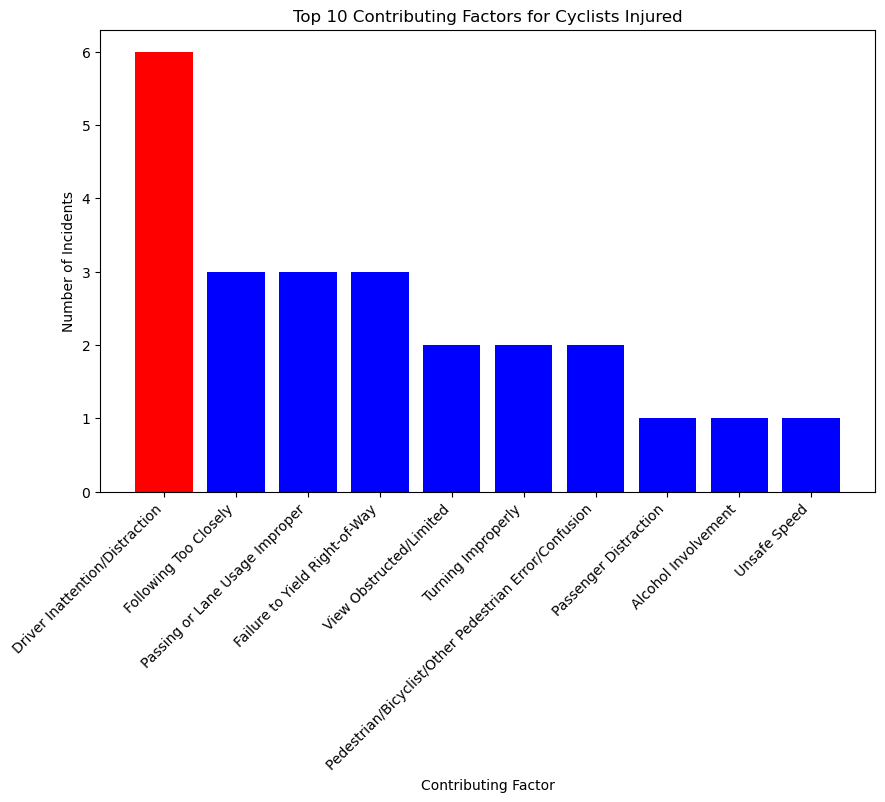

In [21]:
# Convert the column "number_of_cyclist_injured" to numeric
filtered_df["number_of_cyclist_injured"] = pd.to_numeric(filtered_df["number_of_cyclist_injured"], errors="coerce")

# Filter the dataframe for cyclists
cyclist_df = filtered_df[filtered_df["number_of_cyclist_injured"] > 0].copy()

# Get the top 10 contributing factors for cyclists
top_factors_cyclist = cyclist_df["contributing_factor_vehicle_1"].value_counts().nlargest(10)

# Create the plot for cyclists
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart for cyclists
colors = ['r'] + ['b'] * (len(top_factors_cyclist) - 1)  # Set first bar color as red
ax.bar(top_factors_cyclist.index, top_factors_cyclist.values, color=colors)

# Set axis labels and title for cyclists
ax.set_xlabel("Contributing Factor")
ax.set_ylabel("Number of Incidents")
ax.set_title("Top 10 Contributing Factors for Cyclists Injured")

# Rotate x-axis labels diagonally
ax.tick_params(axis='x', rotation=45)

# Adjust the position of x-axis labels
ax.set_xticklabels(top_factors_cyclist.index, rotation=45, ha='right')

# Adjust layout and spacing
plt.tight_layout()

# Save the bar plot for cyclists as a png file
plt.savefig("plots/cyclists_injured_barplot.png")

# Get the top ten contributing factors by volume
top_factors_list3 = top_factors_cyclist.reset_index().values.tolist()
# Print the list of top contributing factors by volume
for factor3 in top_factors_list3:
    print(factor3[0], "-", factor3[1])

# Display the bar plot for pedestrians
plt.show()

## Plots to Investigate How Vehicular Collisions Interact with Other Factors

## Incidence of Crashes by Month of the Year

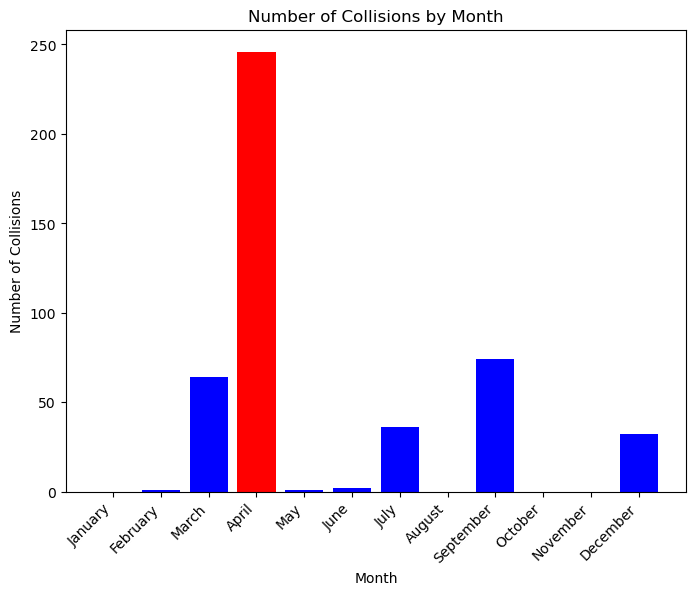

In [22]:
import calendar

# Extract the month digits from the 'crash_date' column
filtered_df['month'] = filtered_df['crash_date'].str[5:7]

# Group the data by month and count the number of collisions
monthly_collisions = filtered_df['month'].value_counts().sort_index()

# Get the month values and number of collisions
months = range(1, 13)
num_collisions = monthly_collisions.reindex([str(month).zfill(2) for month in months], fill_value=0)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Generate bar chart with a darker blue color
colors = ['b'] * 12
colors[3] = 'r'  # Set the April bar color as red
ax.bar(months, num_collisions, color=colors)

# Set x-axis ticks and labels
month_labels = [calendar.month_name[i] for i in range(1, 13)]
ax.set_xticks(months)
ax.set_xticklabels(month_labels, rotation=45, ha='right')

# Set plot labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Number of Collisions')
ax.set_title('Number of Collisions by Month')

# Adjust layout and spacing
plt.tight_layout()

# Save the bar plot for the presentation
plt.savefig("plots/number_of_collisions_by_month.png")

# Display the plot
plt.show()


## Plots to Investigate How Vehicular Collisions Interact with Other Factors

## Relationship Between Time of Day and Accidents

The r-value is: 0.5315547744256138


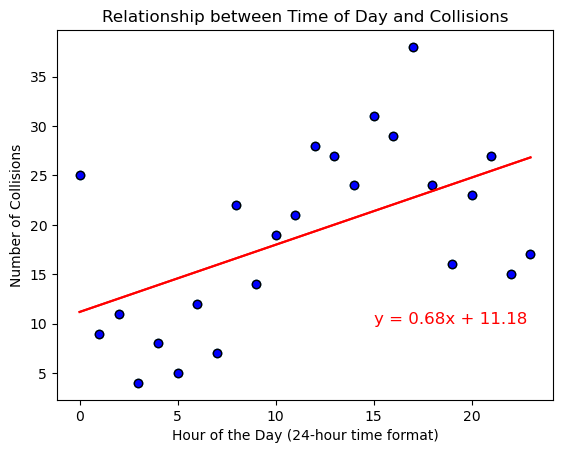

In [23]:
# Generate a scatter plot to see if time of day correlate with more or less collisions by distracted drivers.
# Define a function to create Linear Regression plots and return r-value

def create_linear_regression_plot(x_values, y_values, x_label, y_label, title):
    slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
    regression_values = slope * x_values + intercept
    plt.scatter(x_values, y_values, marker="o", edgecolors="black", c="b")
    plt.plot(x_values, regression_values, "r-")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Create the line equation string
    line_eq = f"y = {round(slope, 2)}x + {round(intercept, 2)}"

    # Add the line equation annotation
    plt.annotate(line_eq, (15, 10), fontsize=12, color="red")

    print(f"The r-value is: {r_value}")
    plt.show()

    return r_value

# Convert the 'crash_time' column to datetime if needed
filtered_df['crash_time'] = pd.to_datetime(filtered_df['crash_time'])

# Extract the hour from the 'crash_time' column
filtered_df['hour'] = filtered_df['crash_time'].dt.hour

# Group the data by hour and count the number of collisions
hourly_collisions = filtered_df.groupby('hour').size().reset_index(name='num_collisions')

# Generate scatter plot
plt.scatter(hourly_collisions['hour'], hourly_collisions['num_collisions'])

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(hourly_collisions['hour'], hourly_collisions['num_collisions'])
x = np.array(hourly_collisions['hour'])
y = slope * x + intercept
plt.plot(x, y, color='red')

# Set plot labels and title
plt.xlabel("Hour of the Day (24-hour time format)")
plt.ylabel('Number of Collisions')
plt.title('Relationship between Time of Day and Collisions')

# Adjust layout and spacing
plt.tight_layout()

# Save the scatter plot as png for the presentation
plt.savefig("plots/relationship_between_time_of_day_and_crashes.png")

# Call the function to create the linear regression plot and get the r-value
r_value = create_linear_regression_plot(hourly_collisions['hour'], hourly_collisions['num_collisions'],
                                        'Hour of the Day (24-hour time format)', 'Number of Collisions', 'Relationship between Time of Day and Collisions')

## Plots to Investigate How Vehicular Collisions Interact with Other Factors

## Breakdown of Accidents by Specific Times of Day (Rush Hours and Lunch Hour)

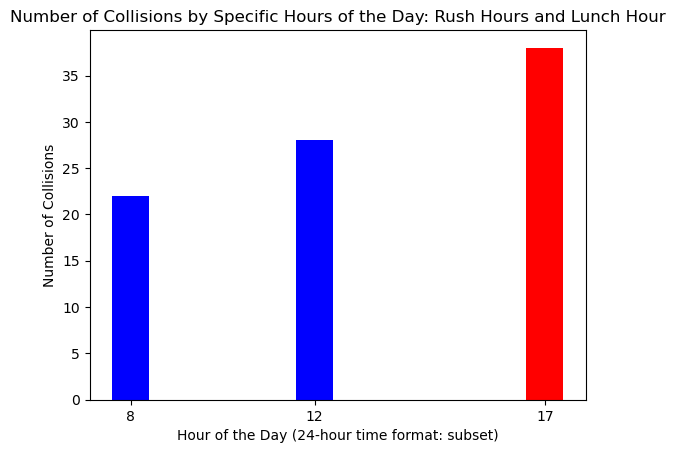

In [24]:
import matplotlib.pyplot as plt

# Filter the data for hours 8, 12, and 17
filtered_df_bar = filtered_df[(filtered_df['hour'] == 8) | (filtered_df['hour'] == 12) | (filtered_df['hour'] == 17)]

# Compute the number of collisions for each hour
hourly_collisions = filtered_df_bar.groupby('hour')['collision_id'].count()

# Determine the hour with the highest number of collisions
highest_hour = hourly_collisions.idxmax()

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(hourly_collisions.index, hourly_collisions.values, color='blue')
ax.bar(highest_hour, hourly_collisions[highest_hour], color='red')

# Set plot labels and title
ax.set_xlabel('Hour of the Day (24-hour time format: subset)')
ax.set_ylabel('Number of Collisions')
ax.set_title('Number of Collisions by Specific Hours of the Day: Rush Hours and Lunch Hour')

# Set x-axis tick labels
ax.set_xticks(hourly_collisions.index)
ax.set_xticklabels(hourly_collisions.index)

# Adjust layout and spacing
plt.tight_layout()

# Save the scatter plot as png for the presentation
plt.savefig("plots/relationship_between_specific_peak_times_of_day_and_crashes.png")

# Show the plot
plt.show()

## Plots to Investigate How Vehicular Collisions Interact with Other Factors

## Breakdown of Accidents by Type of Vehicle

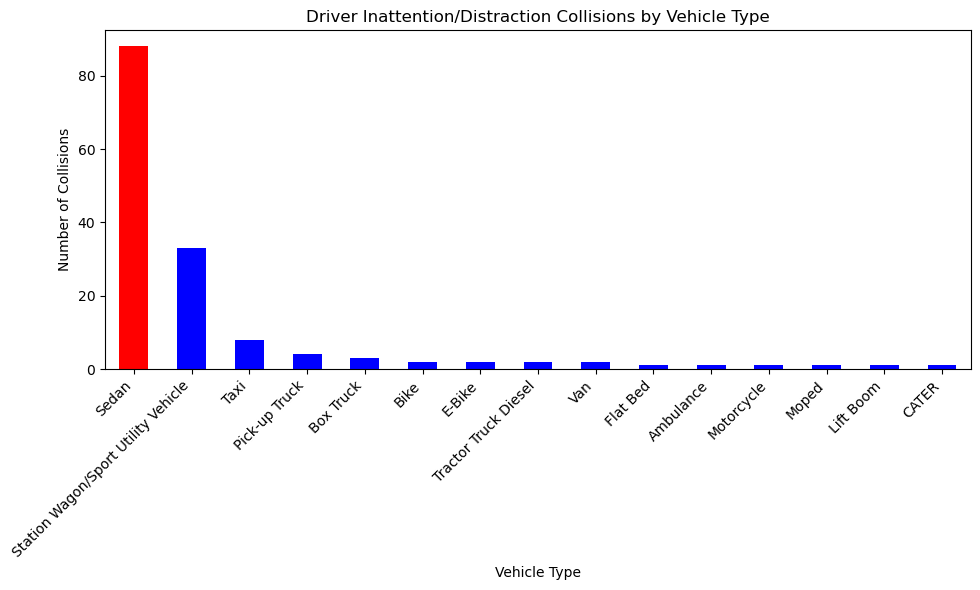

In [25]:
# Generate a bar plot showing the total number of Collisions by Vehicle Type correlated with Driver Inattention/Distraction

# Generate the counts
filtered_SJdf = filtered_df[filtered_df["contributing_factor_vehicle_1"] == "Driver Inattention/Distraction"]
vehicleType_counts = filtered_SJdf["vehicle_type_code1"].value_counts()

# Plot the figure
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
bar_plot = vehicleType_counts.plot(kind="bar", color=['r'] + ['b'] * (len(vehicleType_counts) - 1))
plt.xlabel("Vehicle Type")
plt.ylabel("Number of Collisions")
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels and align them to the right
plt.title('Driver Inattention/Distraction Collisions by Vehicle Type')

# Adjust layout and spacing
plt.tight_layout()

# Save the bar plot as a PNG for the presentation
plt.savefig("plots/relationship_between_vehicle_type_and_crashes.png")

# Show the plot
plt.tight_layout()  # Adjust spacing to prevent label overlap
plt.show()



## Plots to Investigate How Vehicular Collisions Interact with Other Factors

## Breakdown of Accidents by Borough of New York City

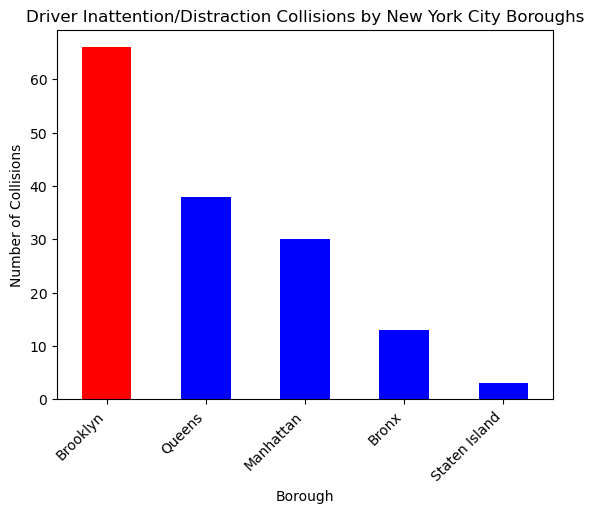

In [26]:
# Generate a bar plot showing the total number of Collisions by Borough correlated with Driver Inattention/Distraction

# Generate the counts
borough_counts = filtered_SJdf["borough"].value_counts()

# Convert borough labels to upper-lower case format
borough_labels = borough_counts.index.str.title()

# Plot the figure
plt.figure()
colors = ['r'] + ['b'] * (len(borough_counts) - 1)  # Set the first bar color as red
bar_plot = borough_counts.plot(kind="bar", color=colors)
bar_plot.set_xlabel("Borough")  # Set x-axis label
bar_plot.set_ylabel("Number of Collisions")  # Set y-axis label
bar_plot.set_xticklabels(borough_labels, rotation=45, ha='right')
plt.title('Driver Inattention/Distraction Collisions by New York City Boroughs')

# Adjust layout and spacing
plt.tight_layout()

# Save the bar plot as a png image
plt.savefig("plots/relationship_between_nyc_borough_and_crashes.png")

# Show the plot
plt.show()